# Globally and Locally Consistent Image Completion

Team Member: Haoyu Yin, Tianhao Chen, Taochen Zhu
* Haoyu Yin: h48yin@uwaterloo.ca
* Tianhao Chen: t345chen@uwaterloo.ca
* Taochen Zhu: t66zhu@uwaterloo.ca


## Abstraction

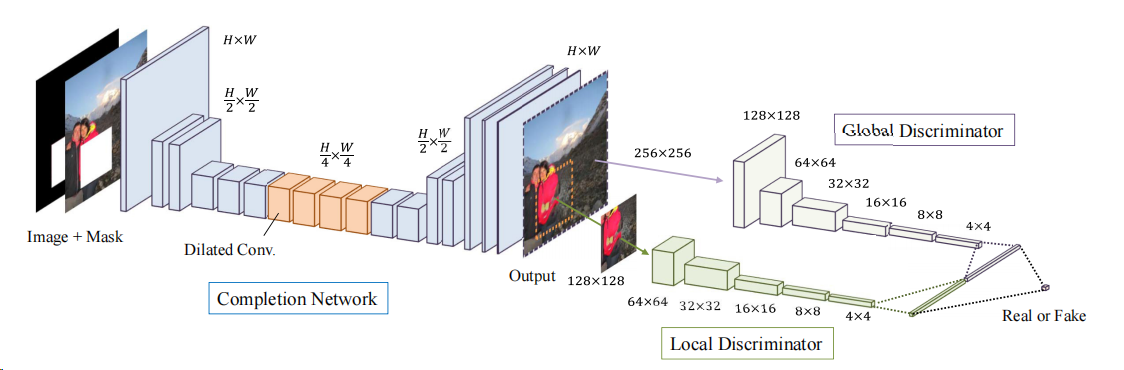

The proposed model comprises two main components: the Generator and the Discriminator. Each plays a crucial role in the graph inpainting process, facilitating the restoration of potentially corrupted graphs.

1. Generator
The Generator's primary function is to synthesize new graph representations from input graphs that have been subjected to alterations (tainted graphs). The objective is to produce outputs that closely approximate the characteristics of untainted, original graphs. The initial phase of model training involves pre-training the Generator. This step aims to refine its ability to replicate the original graph's features accurately, establishing a robust foundation for subsequent training phases.

2. Discriminator
Operating only during the training phase, the Discriminator assesses the authenticity of the graphs, determining whether a graph is an original or has been generated by the Generator. It consists of two sub-components:
    * Global Discriminator: Evaluates the entire graph structure to assess its authenticity.
    * Local Discriminator: Focuses specifically on the inpainted regions of the graph, providing a detailed scrutiny of these areas.
    $$Discriminator=concat(Local\space Discriminator,Global\space Discriminator)$$

The training process is executed in 3 phases, where the first phase is to pre-train the generator, the second phase is to pre-train the discriminator, and the thrid phase is to formally train both discriminator and generator in an adversarial pattern iteratively.

1. Phase 1:
In phase 1, the generator will be pre-trained to generate some images that is as much close as the untainted original input image. This will be a start point for later training. The loss function will be a mean squared error loss between generated image and original input untainted image on the targeted masked part.
$$Loss_{phase1} = MSE(img*mask, generated_img*mask)$$
2. Phase 2:
In phase 2, the discriminator will be pre-trained to identify the images generated by such pre-trained generator. The loss will be binary cross-entropy loss, and the loss of discriminator in this step consists of 2 parts: the first part is a bceloss between output of discriminator with original images as input and a vector of ones; the second part is a bceloss between output of discriminator with generated images as input and a vector of zeros.
$$Loss_{phase2} = BCE(Discriminator(img), ones) + BCE(Discriminator(generated_img), zeros)$$
3. Phase 3:
In phase 3, the formal training stage would start. Which will iteratively train the generator and discrminator and use the performance of discriminator as the loss on each training iteration. In each iteration, the generator will firstly produce a output image, then the discriminator will be trained by using the bce loss same as phase 2.
$$Loss_{Discriminator}=BCE(Discriminator(img),ones)+BCE(Discriminator(generated_img),zeros)$$
After that, the generator will be trained with a goal to "fool" the discriminator, that is, it will learn to produce a image with high reality that discriminator cannot distingish. Meanwhile, we don't want this produced image to be drifted too far away from the input original image since we want to inpaint the original image but not generate a totally different one. So, the loss for generator in this step will be a combination of phase 1 MSE loss and a BCE loss indicating the reality of the generated graph. The ratio between 2 losses is controlled by a super parameter ALPHA.
$$Loss_{Generator}=Loss_{reality}+Loss_{phase1}=ALPHA∗BCE(Discriminator(generated_img),ones)+MSE(generated_img∗mask,img∗mask)$$

Finally, the trained model will be stored in the /model folder.

---

## Team Contribution

* Haoyu Yin(h48yin@uwaterloo.ca): developed python code for the generator and discriminator model, wrote the model description for the documentation, and train the model locally
* Tianhao Chen(t345chen@uwaterloo.ca): modified the generator and discriminator model, developed the TRAIN.ipynb, and trained our final model on Colab
* Taochen Zhu(t66zhu@uwaterloo.ca): trained the model locally, developed the test for the final model, and finish the documentation

## Folder structure

We have three folders for our files

* data: Example pictures to show the performance of trained model. Training datasets were not included in the project files since they were too big.

* model: Trained model .pth files

* script: The folder for our libraries. It includes the layers of the model, training script of the model and some other util functions

### Library (Script folder)

```
script/ 
    |____discriminator.py  
    |____generator.py    
    |____util.py
    |____TRAIN.ipynb
```

* discriminator.py: The class for the Discriminator
* generator.py: The class for the Generator
* util.py: The utils for generating the mask on the image
* TRAIN.ipynb: The file used to train the model on Colab


## Preparation

### Environment

We use the following Python library: 
* `numpy`
* `torch`
* `torchvision`
* `matplotlib`

### Dataset
Download the dataset from this official link. https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

There is a google drive folder contains the img_align_celba.zip
https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg?resourcekey=0-rJlzl934LzC-Xp28GeIBzQ

Note that although pytorch has its own celebA dataset with download option available, gdown can be unavailable and it's better to download the dataset manually. The structure should look like
```
data/
  celeba/
    | img_align_celeba/
    | identity_CelebA.txt
    | list_attr_celeba.txt
    | list_bbox_celeba.txt
    | list_eval_partition.txt
    | list_landmarks_align_celeba.txt
```


## Training

The training procedure consists of the following three phases.

* Phase 1: trains only generator.
* Phase 2: trains only discriminator, while generator is frozen.
* Phase 3: both generator and discriminator are jointly trained.

The main code for this part is in the script/TRAIN.ipynb file.


## Testing the performance

We use the images in the data folder to test the preformance of our trained model

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision.utils import save_image
import torch.utils.data
import torch
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image


from script.generator import *
from script.discriminator import *
from script.util import *

<Figure size 1200x500 with 0 Axes>

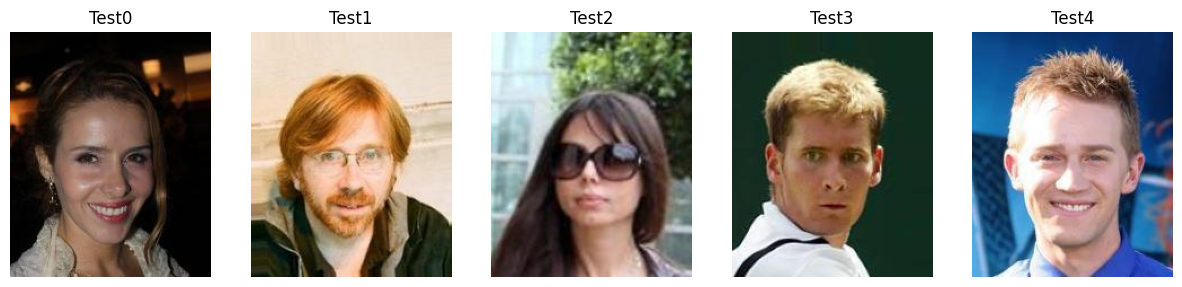

In [3]:
# Load test images from the data folder
img1 = Image.open("images/test_1.jpg")
img2 = Image.open("images/test_2.jpg")
img3 = Image.open("images/test_3.jpg")
img4 = Image.open("images/test_4.jpg")
img5 = Image.open("images/test_5.jpg")
images = [img1, img2, img3, img4, img5]

fig = plt.figure(figsize = (12, 5))
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

# Loop through the images
for i, (ax, image) in enumerate(zip(axs, images)):
    ax.imshow(image, cmap='gray')
    ax.title.set_text('Test' + str(i))
    ax.axis('off')  # Hide the axes ticks

plt.show()

<Figure size 1200x500 with 0 Axes>

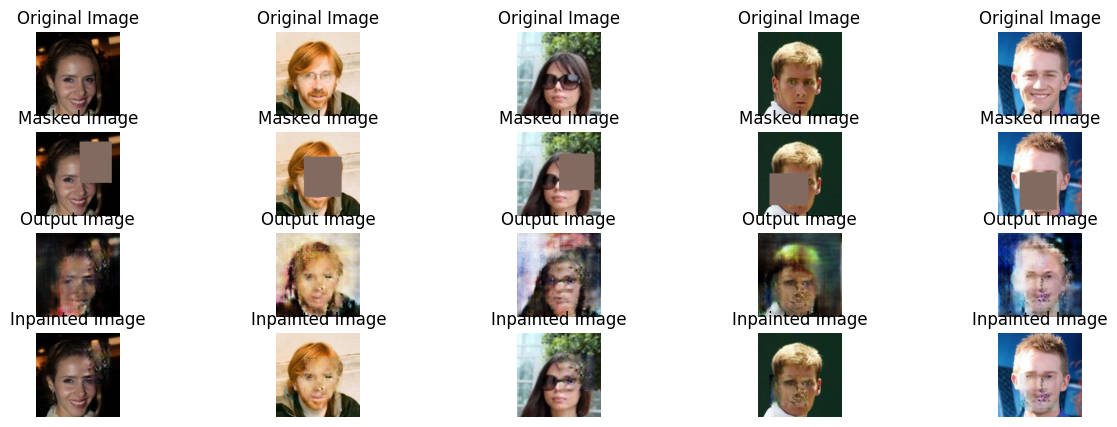

In [4]:
MIN_HOLEW, MAX_HOLEW = 96, 128
MIN_HOLEH, MAX_HOLEH = 96, 128
GPATH = 'model/gen-mutual-20-loss13.787893346045166.pth'
device = torch.device("cpu")

mpv = torch.tensor((0.50925811, 0.42336759, 0.37791181)).view(1, 3, 1, 1).to(device)
generator = Generator().to(device)
checkpoint = torch.load(GPATH)
generator.load_state_dict(checkpoint['model_state_dict'])
generator.eval()

fig = plt.figure(figsize = (12, 5))
fig, axs = plt.subplots(4, 5, figsize=(15, 5))

for i, img in enumerate(images):
    # convert the image to tensor
    img = transforms.Resize(256)(img)
    img = transforms.RandomCrop((256, 256))(img)
    img = transforms.ToTensor()(img)
    img = torch.unsqueeze(img, dim=0)

    # generate the hole for the image
    shape = (img.shape[0], 1, img.shape[2], img.shape[3])
    hole = get_hole((random.randint(MIN_HOLEW, MAX_HOLEW),
                     random.randint(MIN_HOLEH, MAX_HOLEH)))
    mask = get_mask(shape, hole)
    masked_img = img - img * mask + mpv * mask

    # test the output of themodel
    input = torch.cat((masked_img, mask), dim=1)
    out = generator(input)
    imgs = torch.cat((img.cpu(), out.cpu()), dim=0)


    # Convert tensors to PIL images for displaying
    pic_mask = (mask[0][0] == 1)
    inpainted_img = masked_img.clone()
    inpainted_img[:, :, pic_mask] = out[:, :, pic_mask]
    save_image(inpainted_img, 'images/result{}.jpg'.format(i+1), nrow=len(inpainted_img))

    img = img.squeeze(0).detach().numpy()
    masked_img = masked_img.squeeze(0).detach().numpy()
    out = out.squeeze(0).detach().numpy()
    inpainted_img = inpainted_img.squeeze(0).detach().numpy()
    
    img = np.transpose(img, (1, 2, 0))
    masked_img = np.transpose(masked_img, (1, 2, 0))
    out =  np.transpose(out, (1, 2, 0))
    inpainted_img = np.transpose(inpainted_img, (1, 2, 0))
    

    # display the image
    axs[0, i].imshow(img)
    axs[0, i].set_title('Original Image')
    axs[0, i].axis('off')
    
    axs[1, i].imshow(masked_img)
    axs[1, i].set_title('Masked Image')
    axs[1, i].axis('off')

    axs[2, i].imshow(out)
    axs[2, i].set_title('Output Image')
    axs[2, i].axis('off')

    axs[3, i].imshow(inpainted_img)
    axs[3, i].set_title('Inpainted Image')
    axs[3, i].axis('off')


plt.show()
    

We can see from the results that some pictures provides reasonable results, mainly those with no glasses or accessories in their face. Clearly the model doesn't generalize well on those people with sun glasses. However, these results are much better than training the generator alone.

## Conclusion

In conclusion, our image inpainting GAN model demonstrates encouraging reconstructive abilities in certain cases, where it synthesizes realistic textures and colors in the missing parts, harmonizing well with the non-occluded areas of the original images. However, the model's performance varies when confronted with complex backgrounds or extensive masked areas. The reconstructions are notably better for images with simple backgrounds and fewer details.

Technical assessments indicate that the learning depth of our model may be insufficient, which likely contributes to less satisfactory outcomes in challenging scenarios. To enhance the model's performance in these complex contexts, deeper training is necessary, which not only demands an expanded dataset and more training time but also requires higher-performance training hardware. Improvements to the loss functions to more accurately capture the subtleties of human features, or employing a more diverse training dataset, might positively impact the model's inpainting results. For future development, we need to improve these areas to achieve more consistent and precise inpainting across a broader array of images.

Also the paper mentioned post-processing including using poisson blending. If such technique is used, the result can be better presented like the first test would have more consistent brightness and some fuzzy region can blend in the texture of the background better.

## Referenced
Iizuka, S., Simo-Serra, E., & Ishikawa, H. (2017). Globally and locally consistent image completion. ACM Transactions on Graphics, 36(4), 1–14. https://doi.org/10.1145/3072959.3073659